### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [1]:
# Imports

import time
import math
import numpy as np
import imageio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances
from skimage.metrics import structural_similarity
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import convolve2d
from scipy.ndimage import median_filter
from scipy import fftpack

from typing import List
from typing import Tuple
from typing import Callable

import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 150  # Controls the size of the plots.


# 1. Source Image

In [2]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

## 1.1. Load the source image

Loads the grayscale image and crops it into a NumPy array.

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210.0, 0.0, 49.3, 34.8)


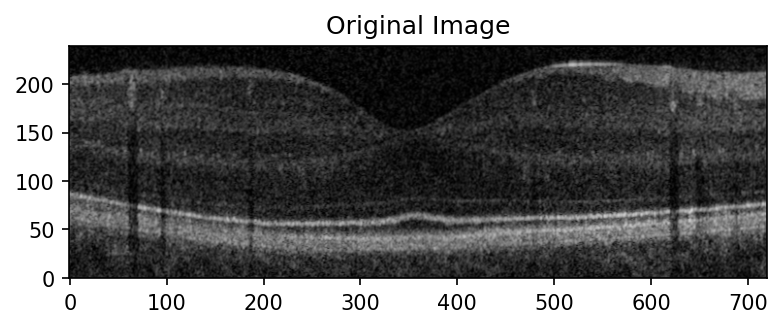

In [3]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]


def draw_image(image):
    """ Draws the grayscale image with black as 0 and white as 255. """
    # use vmin and vmax to stop imshow from scaling
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower')


def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(imageio.imread(imdir+'/'+imname+".png"), mask)).astype(np.float64)
    print("{} {} ({}, {}, {}, {})".format(
        imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)
    ))
    draw_image(image)
    plt.title("Original Image")
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

## 1.2. Traditional Image Processing

Traditional image processing techniques such as blur, constant convolutions, median windows, and FFT denoising can be used to reduce the noise in an image.

Blurred Image: shape=(240, 720), min=2.58, mean=49.27, max=161.90


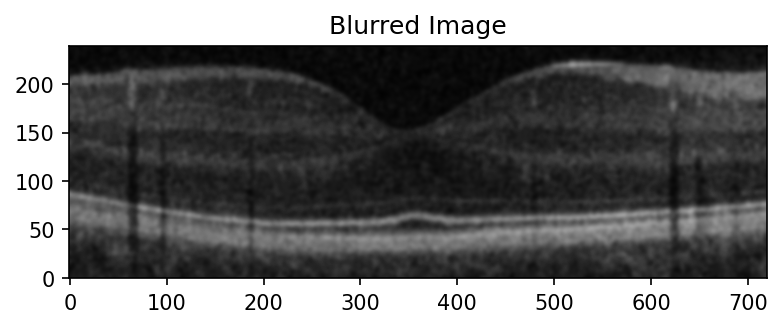

Mean Windowed Image: shape=(240, 720), min=0.11, mean=49.16, max=192.78


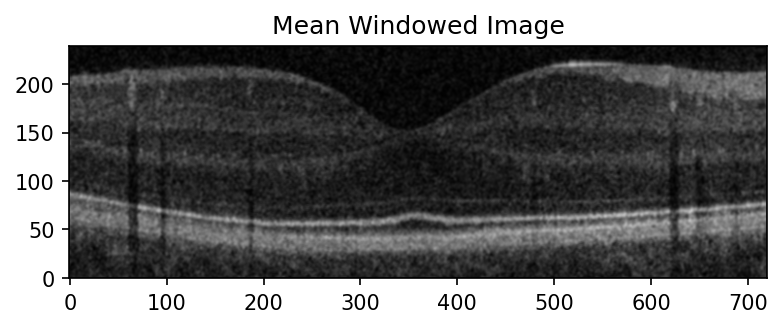

Median Windowed Image: shape=(240, 720), min=0.00, mean=49.24, max=197.00


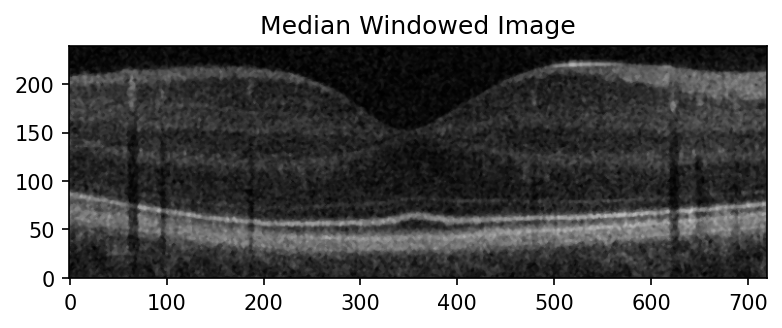

FFT Denoise Image: shape=(240, 720), min=0.00, mean=49.27, max=194.53


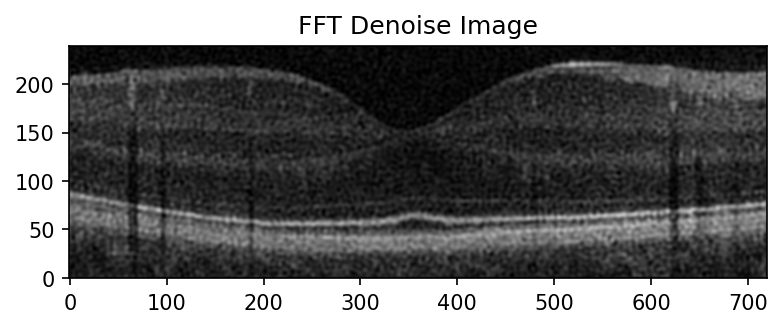

Original Image: shape=(240, 720), min=0.00, mean=49.27, max=210.00


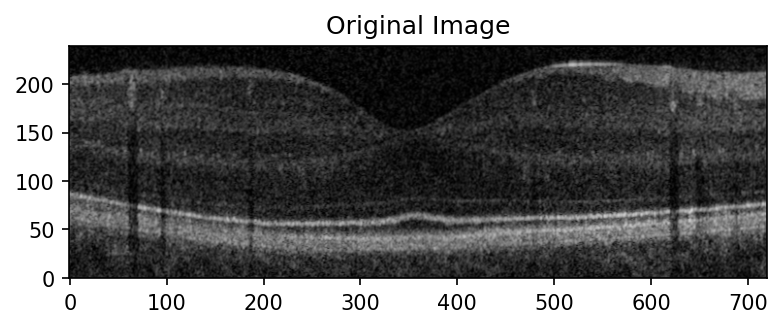

In [4]:
def blur(image, *, sigma=2):
    """ Blur the image using a Gaussian filter. """
    return gaussian_filter(image, sigma=sigma)


def mean_window(image, *, window=3, times=1):
    """ Run an averaging filter over the image. """
    for i in range(times):
        image = convolve2d(image, np.ones((window, window)) / (window**2), mode="same")
    return image


def median_window(image, *, window=3, times=1):
    """ Run an averaging filter over the image. """
    for i in range(times):
        image = median_filter(image, size=window)
    return image


def fft_denoise(image, *, coeff=0.25):
    """
    This uses a 2-dimensional fourier transform and a subsequent
    low-pass filter to reduce high-frequency noise.
    """
    # Compute the fourier transform of the image.
    image_fft = fftpack.fftshift(fftpack.fft2(image))
    
    # Discard high frequencies (which are further from the center of the image).
    w, h = image_fft.shape
    x, y = np.ogrid[0:w, 0:h]
    dist = ((2 * (x - w / 2.0) / w)**2 + (2 * (y - h / 2.0) / h)**2) / 2
    image_fft *= dist < coeff**2

    # Reconstruct the image.
    image = fftpack.ifft2(fftpack.ifftshift(image_fft)).real
    
    # Clamp the image to the range [0, 255]
    return np.minimum(np.maximum(image, 0), 255)


def test_traditional_approach(image, method: Callable, title: str):
    """ Plots the application of a traditional image processing method. """
    processed = method(image)
    print("{}: shape={}, min={:.2f}, mean={:.2f}, max={:.2f}".format(
        title, processed.shape, np.amin(processed), np.mean(processed), np.amax(processed)
    ))
    draw_image(processed)
    plt.title(title)
    plt.show()


test_traditional_approach(image, blur, "Blurred Image")
test_traditional_approach(image, mean_window, "Mean Windowed Image")
test_traditional_approach(image, median_window, "Median Windowed Image")
test_traditional_approach(image, fft_denoise, "FFT Denoise Image")
test_traditional_approach(image, lambda x: x, "Original Image")

## 1.3. Brightening the Image

The above traditional approaches show that there are many ways to reduce noise in an image, but each has their own limitations and benefits. From the above, the median filter looks the best for our purposes of maintaining clear lines in the image for our worms to follow.

However, the image still contains some trends that are very faint compared to others in the image. This can be helped by brightening and darkening the images based upon the brightness if their surroundings.

Scaled Image: shape=(240, 720), min=0.00, mean=59.83, max=255.00


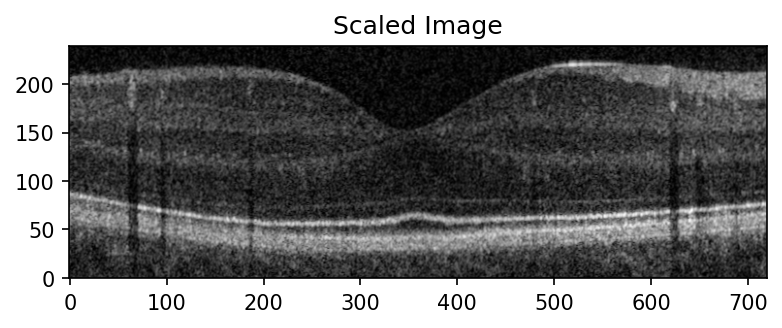

Extremify Image: shape=(240, 720), min=0.00, mean=51.32, max=255.00


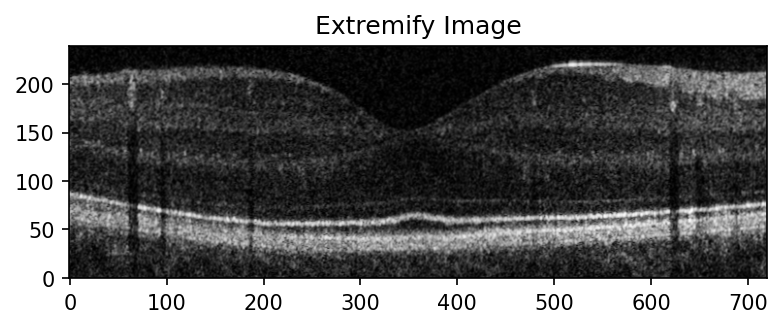

Locally Brightened Image: shape=(240, 720), min=0.00, mean=57.69, max=252.26


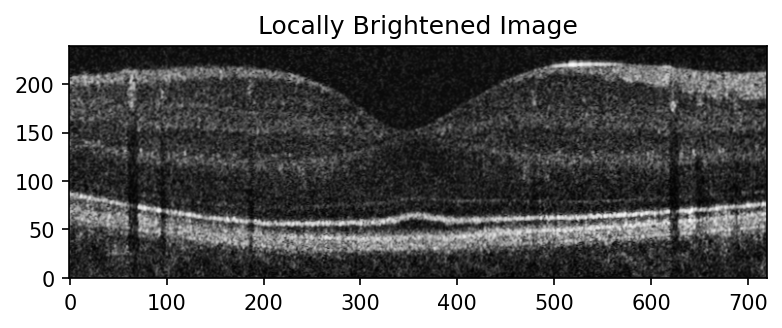

Edge Enhanced Image: shape=(240, 720), min=1.07, mean=55.37, max=252.01


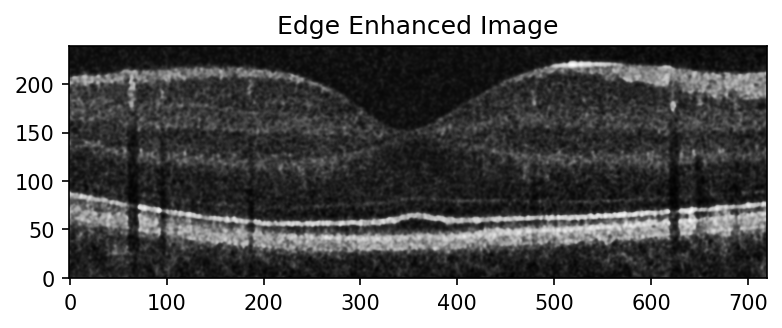

Original Image: shape=(240, 720), min=0.00, mean=49.27, max=210.00


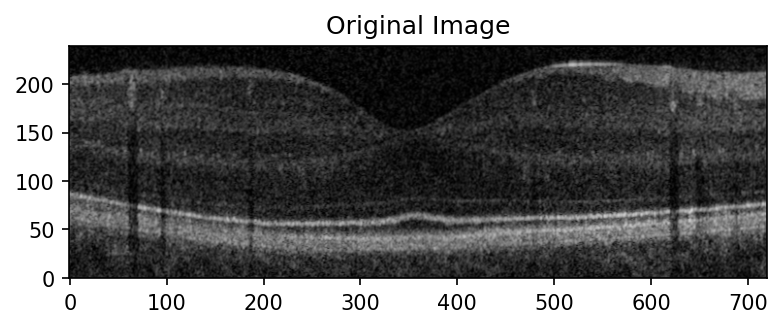

In [5]:
def scale_brighten(image):
    """ Scales the image so that the darkest pixel is 0, and the brightest is 255. """
    return np.interp(image, (image.min(), image.max()), (0.0, 255.0))


def scale_01(image):
    """ Scales the image so that the darkest pixel is 0, and the brightest is 1. """
    return np.interp(image, (image.min(), image.max()), (0.0, 1.0))


def extremify(image, *, coeff=2.0):
    """
    Makes dark pixels darker and bright pixels brighter.
    If coeff is larger, then this is more extreme.
    """
    # This is inspired by the sigmoid function.
    image_01 = 2.0 * (scale_01(image) - 0.5)
    shifted = 1.0 / (1.0 + math.e**((-coeff) * image_01)) - 0.5

    # Scale the image to the range [0, 255]
    return scale_brighten(shifted)


def local_brighten(image, *, local_area_window=30, limit=0.2, scale_coefficient=3.0):
    """ Brightens regions of the image based upon the brightness of their surroundings. """
    # Scale the image into the range [0, 1].
    image = scale_01(image)

    # Use a massive blur to approximate local brightness.
    local_brightness = gaussian_filter(image, sigma=local_area_window)

    # Apply limits so that the image cannot be changed too much.
    local_brightness = np.minimum(np.maximum(local_brightness, limit), 1 - limit)

    # Apply the scaling relative to the local brightness.
    locally_brightened = extremify(image - local_brightness, coeff=scale_coefficient)

    # Combine the original image and the locally brightened image based on the limit.
    return 255 * limit * image + (1 - limit) * locally_brightened


def edge_enhance(image, *, edge_weight=0.5):
    """
    Attempts to enhance lines in the given image using a mixture
    of brightening and darkening different regions of the image,
    and the enhancement of edges.
    """
    # First, locally brighten the image.
    image = local_brighten(blur(image, sigma=1))

    # Mangle the image to help get stronger edges.
    median_image = local_brighten(median_window(blur(image), times=2)) / 255.0

    # Detect its edges using a Sobel convolution.
    kernel_x = np.array(
        [[-2/8, -1/5,  0,  1/5,  2/8],
         [-2/5, -1/2,  0,  1/2,  2/5],
         [-2/4, -1/1,  0,  1/1,  2/4],
         [-2/5, -1/2,  0,  1/2,  2/5],
         [-2/8, -1/5,  0,  1/5,  2/8]]
    )
    kernel_y = np.swapaxes(kernel_x, 0, 1)

    edges_x = convolve2d(median_image, kernel_x, boundary='symm', mode='same')
    edges_y = convolve2d(median_image, kernel_y, boundary='symm', mode='same')
    edges = scale_01(np.sqrt(edges_x**2 + edges_y**2)) * edge_weight

    # Push regions under the edges closer to 0 or 1 using the sigmoid function.
    image = image * (1 - edges) + extremify(image, coeff=6) * edges
    image = np.minimum(np.maximum(image, 0), 255)

    # Brighten the resulting image.
    return image


test_traditional_approach(image, scale_brighten, "Scaled Image")
test_traditional_approach(image, extremify, "Extremify Image")
test_traditional_approach(image, local_brighten, "Locally Brightened Image")
test_traditional_approach(image, edge_enhance, "Edge Enhanced Image")
test_traditional_approach(image, lambda x: x, "Original Image")

With these basic image transformation methods, we can enhance the lines in the image, but not very well. Hopefully our worms can do a better job.

# 2. Worm Representation

The camouflage worms are represented by bezier curves.

In [6]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour

        e_dr = abs(self.dr)
        e_theta = self.theta + (math.pi if self.dr < 0 else 0)
        p0 = [self.x - self.r * np.cos(e_theta), self.y - self.r * np.sin(e_theta)]
        p2 = [self.x + self.r * np.cos(e_theta), self.y + self.r * np.sin(e_theta)]
        p1 = [self.x + e_dr * np.cos(e_theta+self.dgamma), self.y + e_dr * np.sin(e_theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width/2, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = intermediate_points(self)
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)

    def __str__(self):
        return "Camo_Worm({}, {}, {}, {}, {}, {}, {}, {})".format(
            self.x, self.y,
            self.r, self.theta,
            self.dr, self.dgamma,
            self.width, self.colour
        )


## 2.1. Drawing Camo Worms

In [7]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, vmin=0, vmax=255, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None, title=None):
        if save is not None:
            plt.savefig(save)
        if title is not None:
            plt.title(title, fontdict={"fontsize": 20, "fontweight": 700})
        plt.show()


## 2.2. Generating Random Worms

In [8]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm(imshape):
    (radius_std, deviation_std, width_theta) = (10, 5, 4)
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = 10 + radius_std * np.abs(rng.standard_normal())
    theta = math.pi * rng.random()
    dr = deviation_std * rng.standard_normal()
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = 4 + width_theta * rng.standard_gamma(1)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [9]:
# Initialise a random clew

def initialise_clew (size, imshape):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape))
    return clew

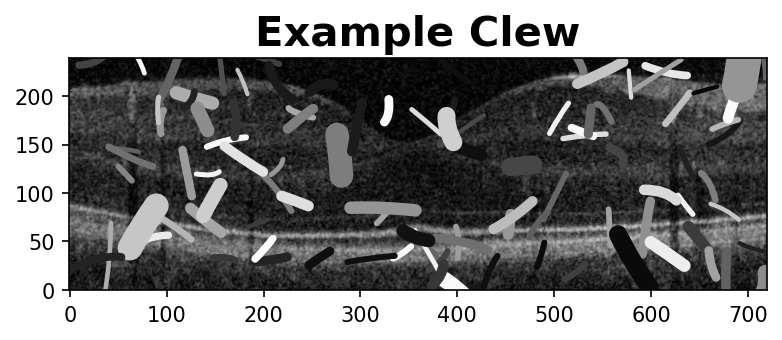

In [10]:
# Initialise clew of 100 and draw

clew = initialise_clew(100, image.shape)
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show(title="Example Clew")

## 2.2. Example Camo Worms

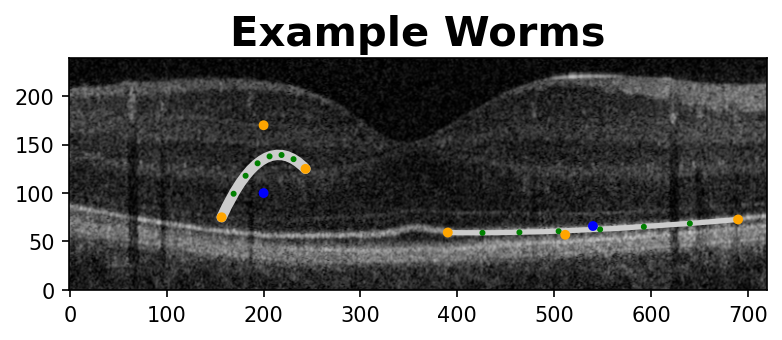

In [11]:
# Draw a single worm along with control points and some sample points

example_worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
example_worm_2 = Camo_Worm(540, 66, 150, np.pi/70, -30, np.pi/12, 5, 0.8)


def draw_example_bezier_png():
    drawing = Drawing(image)
    for worm in [example_worm, example_worm_2]:
        drawing.add_worms(worm)
        drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
        drawing.add_dots(worm.control_points(), color='orange')
        drawing.add_dots((worm.x, worm.y), color='blue')

    drawing.show(save='bezier.png', title="Example Worms")


draw_example_bezier_png()

## 3. Determine what is beneath a worm

Firstly, we will need to determine what pixels are beneath the worm. This is done by creating a mask based on the distance to the worm. To simplify this calculation, we estimate the distance to the worm as the minimum distance to one of N points along the worm. This mask can then be used to filter out only the pixels of the image that fall under the worm.


## 3.1. Reduce the number of points in a curve

The calculation of points on a bezier curve does not give points that are uniformly far apart. Therefore, some sections of the curve would be much more dense than other areas. This wastes computation time. Therefore, the function below filters out the set of points along a curve to only include points that are a certain distance apart.


In [12]:
def filter_out_close_points(points, *, point_interval=6):
    """
    Takes in a numpy array of points, and filters out
    all the points that are closer than point_interval
    together. The exception to this is that the first
    and last points are always kept.
    """
    # 1. Calculate the distances between adjacent points.
    n_points = points.shape[0]
    offsets = points[:-1] - points[1:]
    distances = np.sqrt(offsets[:, 0]**2 + offsets[:, 1]**2)
    
    # 2. Adjust the point_interval so we can evenly space the points.
    total_distance = np.sum(distances)
    point_interval = total_distance / math.ceil(total_distance / point_interval)

    # 3. Create an array to use as a filter for the points.
    point_filter = np.zeros(n_points, dtype=bool)  # An array of which points to keep.
    point_filter[0] = True  # The first and last points should always be kept.
    point_filter[n_points - 1] = True

    # 4. Fill in the point filter.
    curr_dist = 0
    for index in range(1, n_points):
        curr_dist += distances[index - 1]
        if curr_dist >= point_interval:
            point_filter[index] = True
            curr_dist = 0

    # 5. Apply the filter
    return points[np.where(point_filter)]

## 3.2. Generation of circles

We create the mask by drawing a series of circles into a NumPy array. These circle masks can be relatively expensive to compute compared to the generation of the mask. Therefore, we can cache them to save on computation time.

In [13]:
class CircleMask:
    """
    Contains a circular mask.
    """
    cache: list['CircleMask'] = []

    def __init__(self, radius: float):
        self.radius = radius

        # The radius may be fractional, but we need whole pixels.
        self.width = math.ceil(radius) * 2
        self.offset_x = -math.ceil(radius)
        self.offset_y = -math.ceil(radius)

        # Calculate a grid of distances to the center of the mask.
        xx, yy = np.mgrid[
            self.offset_x:(self.offset_x + self.width),
            self.offset_y:(self.offset_y + self.width)
        ]

        # Anti-aliasing.
        self.mask = np.zeros((self.width, self.width), dtype=np.float64)
        count = 0.0
        for offset_x in [-1/4, 0, 1/4]:
            for offset_y in [-1/4, 0, 1/4]:
                count += 1.0

                # Calculate all the pixels falling within the circle, and add them to the mask!
                dist_squared = (xx + offset_x)**2 + (yy + offset_y)**2
                self.mask += dist_squared < (radius**2)

        self.mask /= count
    
    def apply(self, target_mask, x: float, y: float):
        """
        Draws this circle into the target mask with its center at (x, y).
        """
        # We don't care that much about sub-pixel accuracy.
        x = round(x)
        y = round(y)

        # Calculate the bounds in the target mask to paste the circle.
        target_from_x = max(0, x + self.offset_x)
        target_from_y = max(0, y + self.offset_y)
        target_to_x = min(target_mask.shape[0] - 1, x + self.offset_x + self.width)
        target_to_y = min(target_mask.shape[1] - 1, y + self.offset_y + self.width)
        if target_from_x >= target_to_x or target_from_y >= target_to_y:
            return

        # Calculate the bounds in the circle mask to paste.
        circle_from_x = target_from_x - x - self.offset_x
        circle_from_y = target_from_y - y - self.offset_y
        circle_to_x = target_to_x - x - self.offset_x
        circle_to_y = target_to_y - y - self.offset_y

        # Add the circle mask into the target mask.
        target_area = target_mask[target_from_x:target_to_x, target_from_y:target_to_y]
        source_area = self.mask[circle_from_x:circle_to_x, circle_from_y:circle_to_y]
        np.maximum(target_area, source_area, out=target_area)

    @staticmethod
    def get_cached(radius: float) -> 'CircleMask':
        """
        Tries to find a cached circle that is close in size to radius.
        If one can not be found, it creates it.
        """
        # Quantize the radius into 0.25 pixel steps.
        quantized = round(radius * 4)
        
        # Find if we have cached a circle already.
        cache = CircleMask.cache
        if quantized < len(cache):
            cached = cache[quantized]
            if cached is not None:
                return cached

        # Add in None to fill out the cache size.
        if quantized >= len(cache):
            for i in range(len(cache), quantized + 1):
                cache.append(None)

        # Create the circle mask and cache it.
        mask = CircleMask(quantized / 4)
        cache[quantized] = mask
        return mask


## 3.3. Generate a worm mask from a bezier curve

To save on computation time, the masks that we generate only encompass the bounding box of the worm. Offsets are then used to relate the mask to the subset of the image that they represent.

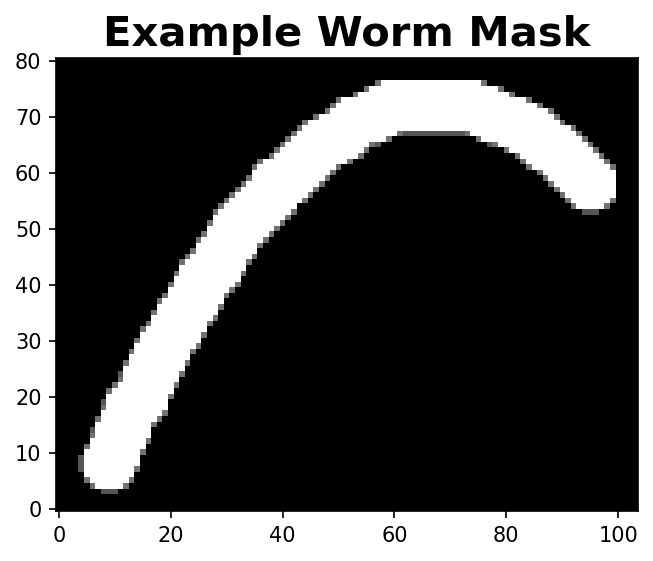

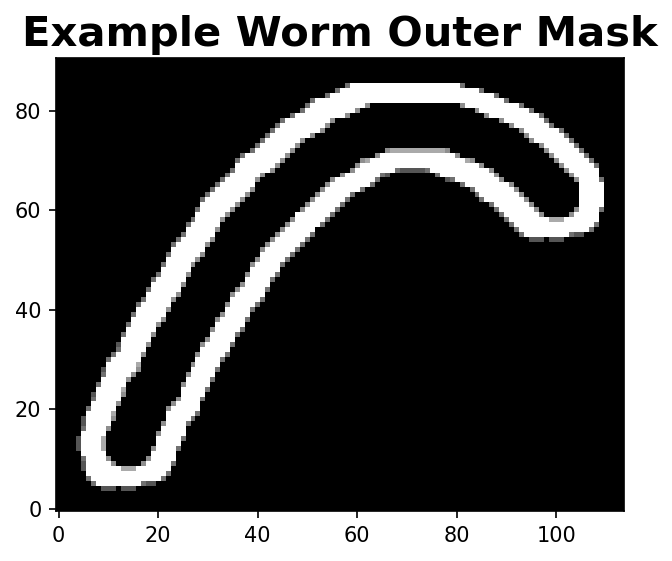

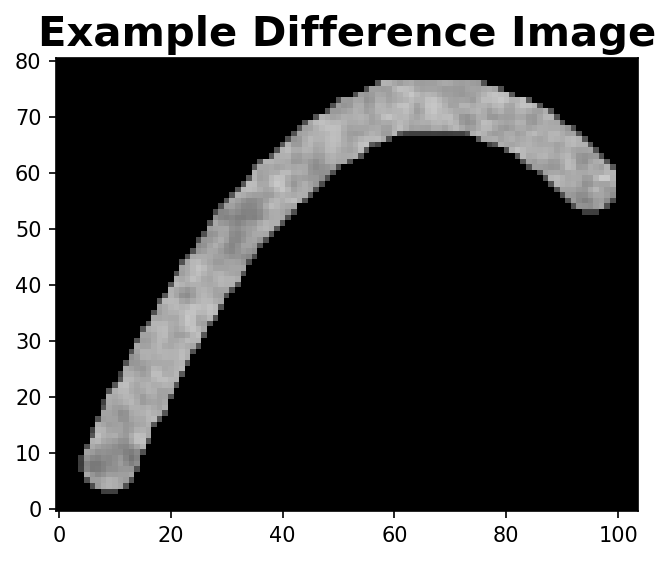

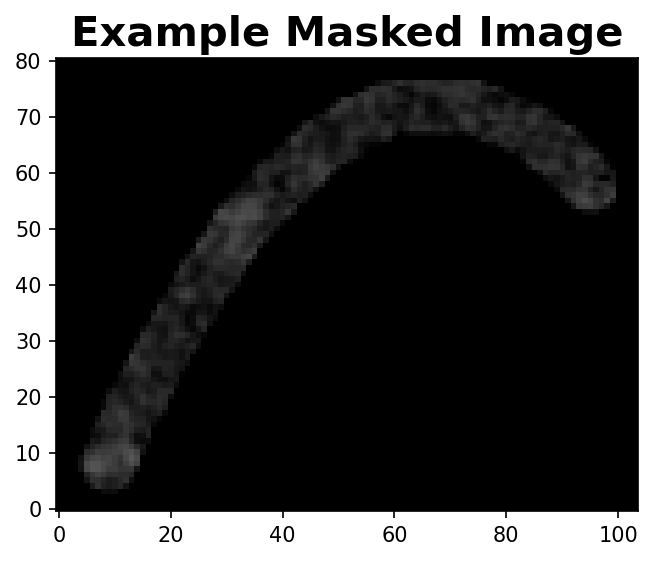

Area = 1280.4, Intersection = 0.6


In [14]:
class WormMask:
    """
    Contains a mask of a worm in an image.
    """
    def __init__(self, worm: Camo_Worm, image, *, copy: 'WormMask'=None):
        self.worm = worm
        self.image = image

        if copy is not None:
            self.min_x = copy.min_x
            self.min_y = copy.min_y
            self.max_x = copy.max_x
            self.max_y = copy.max_y
            self.width = copy.width
            self.height = copy.height
            self.mask = copy.mask
        else:
            # 1. Calculate some information about the worm
            img_width, img_height = image.shape
            radius = worm.width / 2  # This bias is arbitrary
            self.points = worm.bezier(np.linspace(0, 1, num=500))
            self.min_x = max(0, math.floor(np.amin(self.points[:, 1])) - math.ceil(radius*1.5))
            self.min_y = max(0, math.floor(np.amin(self.points[:, 0])) - math.ceil(radius*1.5))
            max_x = min(img_width, math.ceil(np.amax(self.points[:, 1])) + math.ceil(radius*1.5))
            max_y = min(img_height, math.ceil(np.amax(self.points[:, 0])) + math.ceil(radius*1.5))
            width = max_x - self.min_x
            height = max_y - self.min_y

            # If the worm is outside of the image, then we just use a dummy empty 1x1 mask.
            if width <= 0 or height <= 0:
                self.min_x = 0
                self.min_y = 0
                self.mask = np.zeros((1, 1))
            else:
                # 2. Some points are really close together, so we can filter some of them out for speed.
                self.points = filter_out_close_points(self.points, point_interval=radius/2)
                n_points = self.points.shape[0]

                # 3. Apply a circle mask at each point on the curve to the mask.
                self.mask = np.zeros((width, height))
                circle_mask = CircleMask.get_cached(radius)
                for y, x in self.points:
                    circle_mask.apply(self.mask, x - self.min_x, y - self.min_y)

            self.area = np.sum(self.mask)
            self.width = self.mask.shape[0]
            self.height = self.mask.shape[1]
            self.max_x = self.min_x + self.width
            self.max_y = self.min_y + self.height

    def copy(self):
        """ Generates a copy of this worm. """
        return WormMask(self.worm, self.image, copy=self)

    def create_outer_mask(self) -> 'WormMask':
        """
        Generates a mask encompassing the sides of this mask.
        """
        distance = max(1, round(self.worm.width / 2.0))

        # Create the new mask.
        outer_mask = self.copy()
        outer_mask.min_x -= distance
        outer_mask.min_y -= distance
        outer_mask.max_x += distance
        outer_mask.max_y += distance
        outer_mask.width += 2 * distance
        outer_mask.height += 2 * distance
        outer_mask.mask = np.zeros((outer_mask.width, outer_mask.height))

        # Paste the mask a few times.
        root2 = math.sqrt(2)
        for dx in [-distance, 0, distance]:
            for dy in [-distance, 0, distance]:
                if dx == 0 and dy == 0:
                    continue
                if dx != 0 and dy != 0:
                    dx = round(dx / root2)
                    dy = round(dy / root2)

                subsection = outer_mask.mask[
                    (distance + dx):(distance + dx + self.width),
                    (distance + dy):(distance + dy + self.height)
                ]
                np.maximum(subsection, self.mask, subsection)

        # Subtract the original mask.
        original = outer_mask.mask[
            distance:(distance + self.width),
            distance:(distance + self.height)
        ]
        np.minimum(original, 1 - self.mask, original)

        # Crop the mask to the bounds of the image.
        min_x = max(0, outer_mask.min_x)
        min_y = max(0, outer_mask.min_y)
        max_x = min(self.image.shape[0], outer_mask.max_x)
        max_y = min(self.image.shape[1], outer_mask.max_y)
        outer_mask.width = max_x - min_x
        outer_mask.height = max_y - min_y
        outer_mask.mask = outer_mask.mask[
            (min_x - outer_mask.min_x):(min_x - outer_mask.min_x + outer_mask.width),
            (min_y - outer_mask.min_y):(min_y - outer_mask.min_y + outer_mask.height)
        ]
        outer_mask.min_x = min_x
        outer_mask.min_y = min_y
        outer_mask.max_x = max_x
        outer_mask.max_y = max_y

        # Update the area of the mask.
        outer_mask.area = np.sum(outer_mask.mask)
        return outer_mask
        

    def draw_into(self, image, colour):
        """
        Draws this worm mask into the given image with the given colour.
        """
        # 1. Get the subsection that corresponds to the mask.
        image_subsection = image[self.min_x:self.max_x, self.min_y:self.max_y]
        
        # 2. Black-out the area under the mask.
        np.subtract(image_subsection, image_subsection * self.mask, image_subsection)
        
        # 3. Add in the colour for the masked area.
        np.add(image_subsection, colour * self.mask, image_subsection)
        

    def image_within_bounds(self, image=None):
        """
        Returns the image under the mask with the pixels
        not within the mask being marked as 0.
        """
        image = self.image if image is None else image

        # Get the subset of the image corresponding to this mask.
        return image[self.min_x:self.max_x, self.min_y:self.max_y] / 255.0

    def image_under_mask(self, image=None):
        """
        Returns the image under the mask with the pixels
        not within the mask being marked as 0.
        """
        # Apply the mask to the image.
        return self.image_within_bounds(image) * self.mask

    def difference_image(self, image=None):
        """
        This applies this mask to the image, to calculate the differences
        between the colour of the worm and all the pixels beneath the worm.
        """
        # 1. Calculate the difference of the colour of the worm to its background.
        diff_image = np.absolute(self.image_under_mask(image) - self.worm.colour)

        # 2. Apply the mask to the difference.
        return diff_image * self.mask

    @property
    def mean_colour(self):
        """
        Returns the mean colour of all pixels underneath this mask in the image.
        """
        if self.area == 0:
            return None

        return np.sum(self.image_under_mask()) / self.area

    @property
    def mode_colour(self):
        """
        Returns the most common colour of all pixels underneath this mask in the image.
        """
        if self.area == 0:
            return None

        # We want 0 to represent that a pixel is not under the worm.
        sub_image = self.image_within_bounds() + 1
        sub_image = sub_image * self.mask

        colours = np.sort(sub_image.flatten())
        first_index = np.flatnonzero(colours > 0)[0]
        mode_index = math.floor((first_index + len(colours) - 1) / 2.0)
        return colours[mode_index] - 1

    def subsection(self, min_x, min_y, max_x, max_y):
        """
        Gets the subsection of this mask that covers the given coordinates.
        """
        if max_x <= self.min_x or max_y <= self.min_y:
            return None
        if min_x > self.max_x or min_y > self.max_y:
            return None

        min_x = max(self.min_x, min_x)
        min_y = max(self.min_y, min_y)
        max_x = min(self.max_x, max_x)
        max_y = min(self.max_y, max_y)
        return self.mask[
            (min_x - self.min_x):(max_x - self.min_x),
            (min_y - self.min_y):(max_y - self.min_y)
        ]

    def intersection(self, other: 'WormMask'):
        """
        Calculates the area that intersects between this mask and other.
        """
        sub_self = self.subsection(other.min_x, other.min_y, other.max_x, other.max_y)
        if sub_self is None:
            return 0

        sub_other = other.subsection(self.min_x, self.min_y, self.max_x, self.max_y)
        return 2 * np.sum(np.minimum(sub_self, sub_other)) / max(1, self.area + other.area)

    def midpoint_distance_squared(self, other: 'WormMask'):
        """
        Calculates the distance between the midpoints between this mask and other.
        """
        p1 = self.points[math.floor(len(self.points) / 2)]
        p2 = other.points[math.floor(len(other.points) / 2)]
        return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2


# Compare the generated mask with the worm used in the example above.
worm_mask = WormMask(example_worm, image)
Drawing(worm_mask.mask * 255).show(title="Example Worm Mask")
Drawing(worm_mask.create_outer_mask().mask * 255).show(title="Example Worm Outer Mask")
Drawing(worm_mask.difference_image() * 255).show(title="Example Difference Image")
Drawing(worm_mask.image_under_mask() * 255).show(title="Example Masked Image")

example_intersecting_worm = Camo_Worm(200, 100 + 5, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
intersecting_worm_mask = WormMask(example_intersecting_worm, image)
print("Area = {:.1f}, Intersection = {:.1f}".format(worm_mask.area, worm_mask.intersection(intersecting_worm_mask)))


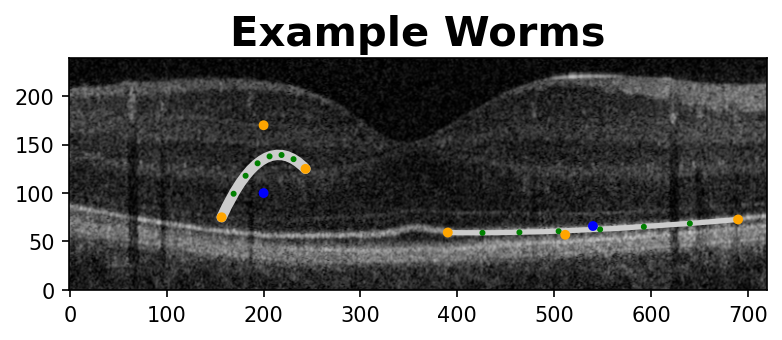

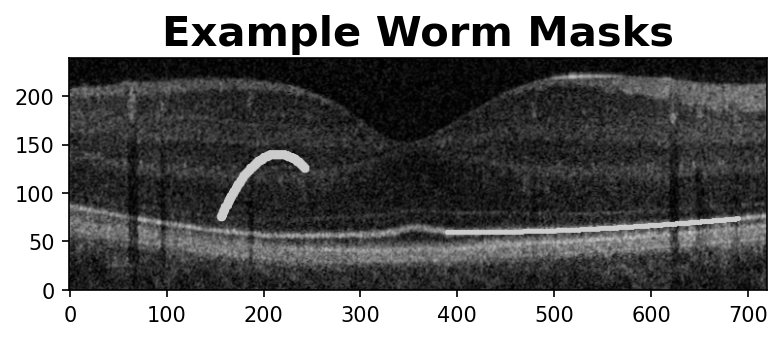

In [15]:
draw_example_bezier_png()

# Draw the masks to visualise their similarities to the real curves.
image_with_worm_masks = image.copy()
for worm in [example_worm, example_worm_2]:
    mask = WormMask(worm, image)
    mask.draw_into(image_with_worm_masks, worm.colour * 255.0)

Drawing(image_with_worm_masks).show(title="Example Worm Masks")


## 4. Optimisation Algorithm

In [16]:
class GeneticClewEvolution:
    """
    Provides methods to evolve a clew of camo worms
    to clean up an image using a basic genetic algorithm.
    """
    def __init__(self, image, clew: List[Camo_Worm], *, name="Clew"):
        self.name = name
        self.image = image
        self.clew = clew
        self.clew_masks = [WormMask(worm, image) for worm in clew]
        for index in range(len(self.clew)):
            colour = self.clew_masks[index].mean_colour
            if colour is not None:
                self.clew[index].colour = self.clew_masks[index].mean_colour

        self.generation = 0
        self.generation_scores = [self.score_clew()]

    def score(self, worm: Camo_Worm, worm_mask: WormMask) -> float:
        """
        Calculates the score of the given worm.
        """
        raise Exception("score is unimplemented for {}".format(type(self).__name__))

    def update(self, worm: Camo_Worm, worm_mask: WormMask) -> Tuple[Camo_Worm, WormMask]:
        """
        Creates
        """
        raise Exception("update is unimplemented for {}".format(type(self).__name__))

    def score_clew(self) -> float:
        """
        Compares the image generated by drawing all worms in the clew
        to the original image. This uses the structural similarity
        index to compare the images.
        A value of 1 is the best possible comparison, and -1 is the
        worst possible comparison.
        """
        generated = self.draw_clew()
        return structural_similarity(self.image, generated, data_range=255)

    def draw_clew(self, image=None):
        """
        Draws the worm masks of the worms in the clew into image.
        """
        image = np.zeros(self.image.shape) if image is None else image
        image = image.copy()

        for worm, mask in zip(self.clew, self.clew_masks):
            mask.draw_into(image, worm.colour * 255.0)

        return image
    
    def plot_clew(self, include_target_image: bool = False):
        """
        Draws the current clew of worms on the image.
        """
        if include_target_image:
            drawing = Drawing(self.image)
            drawing.show(title="Target Image")

        background = self.image * 0.5
        drawing = Drawing(self.draw_clew(background))
        drawing.show(title="{} gen-{}".format(self.name, self.generation))

    def run_generations(self, generations):
        """
        Runs the given number of generations of evolution.
        """
        for i in range(generations):
            self.run_generation()

    def run_generation(self):
        """
        Evolves a single generation.
        """
        start_time = time.time()

        for index in range(len(self.clew)):
            worm = self.clew[index]
            worm_mask = self.clew_masks[index]
            new_worm, new_worm_mask = self.update(worm, worm_mask)
            self.clew[index] = new_worm
            self.clew_masks[index] = new_worm_mask

        self.generation += 1

        new_score = self.score_clew()
        self.generation_scores.append(new_score)

        duration = time.time() - start_time
        print("Generation {}: {:.3f}  (took {:.2f} seconds)".format(
            self.generation, new_score, duration
        ))


In [17]:
def clamp(num, minimum, maximum):
    """
    Returns the closest value to num within the range [minimum, maximum].
    """
    if num < minimum:
        return minimum
    if num > maximum:
        return maximum
    return num

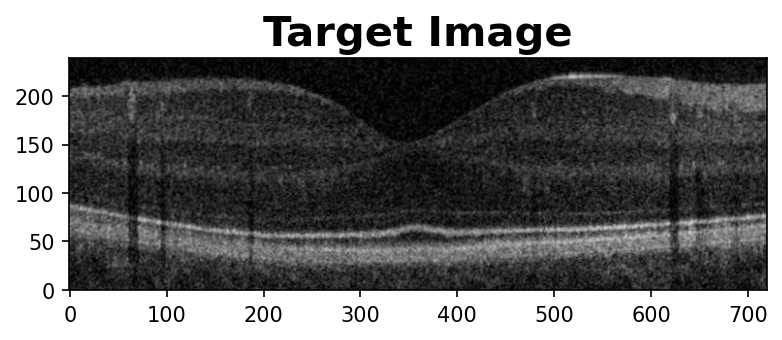

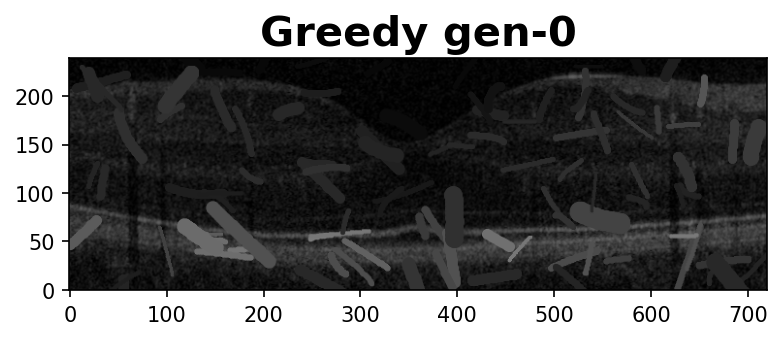

In [18]:
class GreedyClewEvolution(GeneticClewEvolution):
    """
    A basic implementation of clew evolution to get the ball rolling.
    This implementation just makes random mutations and only keeps
    mutations that improve the score of the worm.
    """
    def __init__(self, image, clew: List[Camo_Worm]):
        super().__init__(image, clew, name="Greedy")
        self.edge_enhanced_image = edge_enhance(image)

    def score(self, worm: Camo_Worm, worm_mask: WormMask):
        """ A basic benchmark scoring function. """
        score = 0

        # Promotes the worms being similar colour to their background.
        score -= 100 * np.sum(worm_mask.difference_image()) / max(1, worm_mask.area)

        # Promotes the regions outside the worm being dissimilar colour.
        outer_mask = worm_mask.create_outer_mask()
        score += 50 * np.sum(outer_mask.difference_image()) / max(1, outer_mask.area)

        # Promotes bigger worms.
        score += 0.4 * worm.width + 0.2 * worm.r

        # Attempts to avoid overlapping and close worms.
        close_penalty = 0
        overlap_penalty = 0
        for other_index in range(len(self.clew)):
            other_worm = self.clew[other_index]
            # Give earlier worms in the clew priority
            if worm is other_worm:
                break

            other_worm_mask = self.clew_masks[other_index]
            close_penalty += max(0, 500 - worm_mask.midpoint_distance_squared(other_worm_mask))
            overlap_penalty += max(0, worm_mask.intersection(other_worm_mask) - 0.1)  # Allow 10% overlap

        score -= 0.01 * close_penalty
        score -= 20 * overlap_penalty

        return score

    def random_mutate(self, worm: Camo_Worm, worm_mask: WormMask, score: float,
                      new_location, new_length, new_orientation,
                      new_shape, new_width) -> Tuple[Camo_Worm, WormMask]:

        # We make bigger mutations to worms with lower scores.
        temp = 5 * clamp(1 - score / 3000, 0.01, 1.0)
        if rng.random() < 0.1:
            temp = 5

        x = worm.x + 4 * rng.standard_normal() * temp
        y = worm.y + 4 * rng.standard_normal() * temp
        r = worm.r + 1 * rng.standard_normal() * temp
        theta = worm.theta + math.pi / 2 * rng.standard_normal() * temp
        dr = worm.dr + rng.standard_normal() * temp
        dgamma = worm.dgamma + math.pi * rng.standard_normal() * temp
        width = worm.width + rng.standard_normal()

        new_worm = Camo_Worm(
            worm.x      if not new_location else clamp(x, 0, self.image.shape[1]),
            worm.y      if not new_location else clamp(y, 0, self.image.shape[0]),
            worm.r      if not new_length else clamp(r, 10, 500),
            worm.theta  if not new_orientation else (theta + math.pi / 2) % (math.pi / 2),
            worm.dr     if not new_shape else clamp(dr, -50, 50),
            worm.dgamma if not new_shape else (dgamma + math.pi) % math.pi,
            worm.width  if not new_width else clamp(width, 2, 20),
            worm.colour
        )

        # Determine the colour based on their background.
        new_worm_mask = WormMask(new_worm, self.image)
        new_colour = new_worm_mask.mean_colour
        if new_colour is not None:
            new_worm.colour = clamp(new_colour, 0.1, 1)

        return new_worm, new_worm_mask

    def update(self, worm: Camo_Worm, worm_mask: WormMask) -> Tuple[Camo_Worm, WormMask]:
        """ A basic greedy update function based upon random mutations to the worm. """
        worm_score = self.score(worm, worm_mask)

        new_worm = worm
        new_worm_mask = worm_mask
        new_score = worm_score

        # Try some random mutations to try improve the worm.
        for i in range(3):
            mutated_worm, mutated_worm_mask = self.random_mutate(
                worm, worm_mask, worm_score,
                i > 0,   # new_location
                i == 0,  # new_length
                i == 1,  # new_orientation
                i == 0,  # new_shape
                i == 2   # new_width
            )
            mutated_score = self.score(mutated_worm, mutated_worm_mask)
            if mutated_score > new_score:
                new_worm = mutated_worm
                new_worm_mask = mutated_worm_mask
                new_score = mutated_score

        return new_worm, new_worm_mask



clew = initialise_clew(100, image.shape)
ga = GreedyClewEvolution(image, clew)
ga.plot_clew(include_target_image=True)


Now, we can run the genetic algorithm using our basic functions as a baseline test.

Generation 1: 0.050  (took 0.30 seconds)


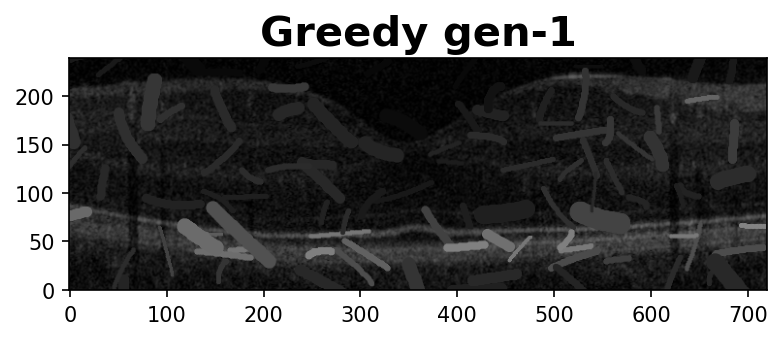

In [19]:
ga.run_generation()
ga.plot_clew()

Generation 2: 0.048  (took 0.31 seconds)
Generation 3: 0.047  (took 0.30 seconds)
Generation 4: 0.047  (took 0.30 seconds)
Generation 5: 0.048  (took 0.30 seconds)
Generation 6: 0.048  (took 0.30 seconds)
Generation 7: 0.049  (took 0.30 seconds)
Generation 8: 0.049  (took 0.30 seconds)
Generation 9: 0.049  (took 0.30 seconds)
Generation 10: 0.049  (took 0.30 seconds)


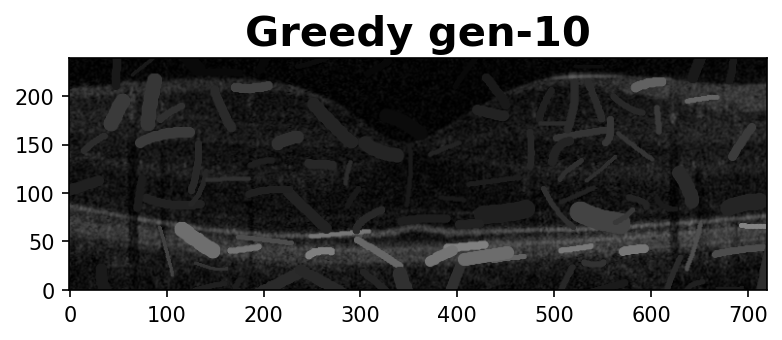

In [20]:
ga.run_generations(9)
ga.plot_clew()

Generation 11: 0.050  (took 0.30 seconds)
Generation 12: 0.050  (took 0.30 seconds)
Generation 13: 0.051  (took 0.30 seconds)
Generation 14: 0.050  (took 0.30 seconds)
Generation 15: 0.050  (took 0.30 seconds)
Generation 16: 0.049  (took 0.30 seconds)
Generation 17: 0.050  (took 0.30 seconds)
Generation 18: 0.050  (took 0.30 seconds)
Generation 19: 0.050  (took 0.30 seconds)
Generation 20: 0.049  (took 0.30 seconds)


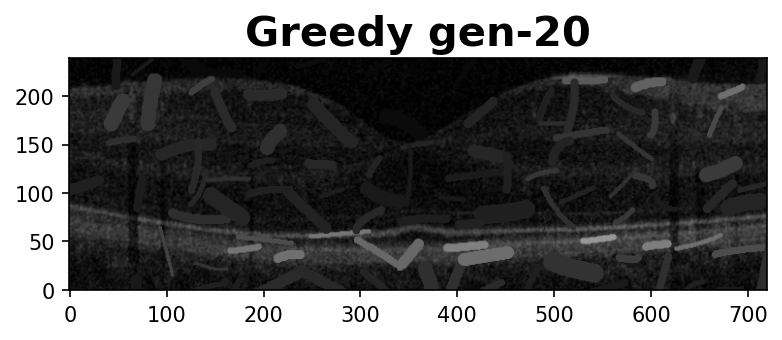

In [21]:
ga.run_generations(10)
ga.plot_clew()

Generation 21: 0.049  (took 0.32 seconds)
Generation 22: 0.052  (took 0.30 seconds)
Generation 23: 0.052  (took 0.30 seconds)
Generation 24: 0.053  (took 0.30 seconds)
Generation 25: 0.053  (took 0.30 seconds)
Generation 26: 0.053  (took 0.30 seconds)
Generation 27: 0.053  (took 0.30 seconds)
Generation 28: 0.052  (took 0.30 seconds)
Generation 29: 0.052  (took 0.30 seconds)
Generation 30: 0.052  (took 0.30 seconds)


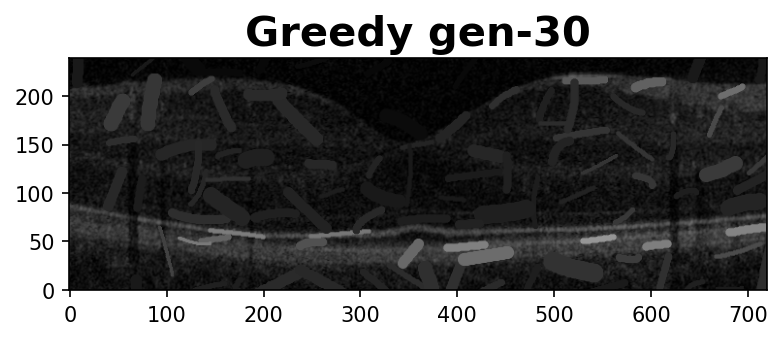

In [22]:
ga.run_generations(10)
ga.plot_clew()

Generation 31: 0.052  (took 0.30 seconds)
Generation 32: 0.053  (took 0.30 seconds)
Generation 33: 0.052  (took 0.30 seconds)
Generation 34: 0.052  (took 0.30 seconds)
Generation 35: 0.052  (took 0.30 seconds)
Generation 36: 0.053  (took 0.30 seconds)
Generation 37: 0.053  (took 0.30 seconds)
Generation 38: 0.053  (took 0.30 seconds)
Generation 39: 0.054  (took 0.29 seconds)
Generation 40: 0.054  (took 0.29 seconds)


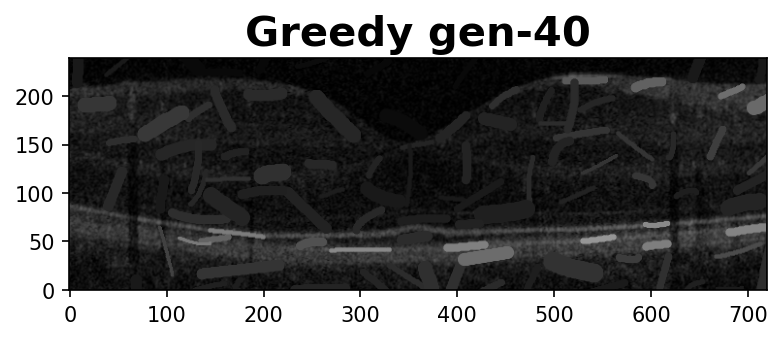

In [23]:
ga.run_generations(10)
ga.plot_clew()

Generation 41: 0.054  (took 0.30 seconds)
Generation 42: 0.054  (took 0.30 seconds)
Generation 43: 0.053  (took 0.29 seconds)
Generation 44: 0.052  (took 0.29 seconds)
Generation 45: 0.050  (took 0.29 seconds)
Generation 46: 0.050  (took 0.29 seconds)
Generation 47: 0.051  (took 0.29 seconds)
Generation 48: 0.051  (took 0.30 seconds)
Generation 49: 0.051  (took 0.29 seconds)
Generation 50: 0.051  (took 0.29 seconds)


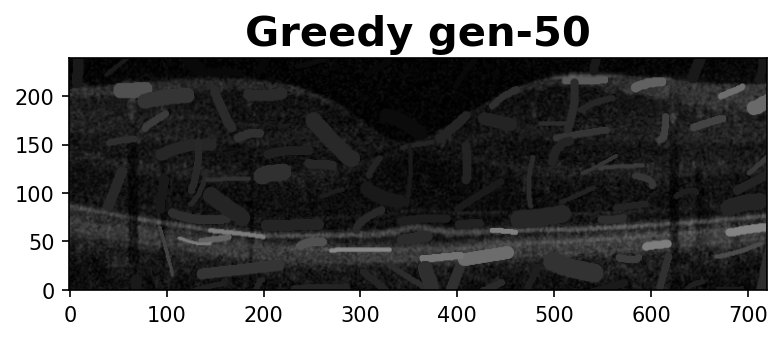

In [24]:
ga.run_generations(10)
ga.plot_clew()

Generation 51: 0.051  (took 0.30 seconds)
Generation 52: 0.051  (took 0.29 seconds)
Generation 53: 0.051  (took 0.30 seconds)
Generation 54: 0.051  (took 0.30 seconds)
Generation 55: 0.051  (took 0.29 seconds)
Generation 56: 0.051  (took 0.29 seconds)
Generation 57: 0.052  (took 0.29 seconds)
Generation 58: 0.052  (took 0.30 seconds)
Generation 59: 0.052  (took 0.29 seconds)
Generation 60: 0.052  (took 0.30 seconds)


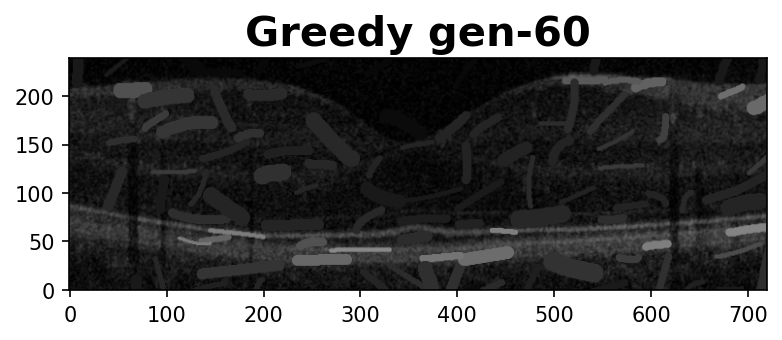

In [25]:
ga.run_generations(10)
ga.plot_clew()

Generation 61: 0.053  (took 0.30 seconds)
Generation 62: 0.053  (took 0.30 seconds)
Generation 63: 0.053  (took 0.30 seconds)
Generation 64: 0.053  (took 0.30 seconds)
Generation 65: 0.055  (took 0.29 seconds)
Generation 66: 0.055  (took 0.30 seconds)
Generation 67: 0.055  (took 0.29 seconds)
Generation 68: 0.053  (took 0.29 seconds)
Generation 69: 0.053  (took 0.30 seconds)
Generation 70: 0.052  (took 0.30 seconds)


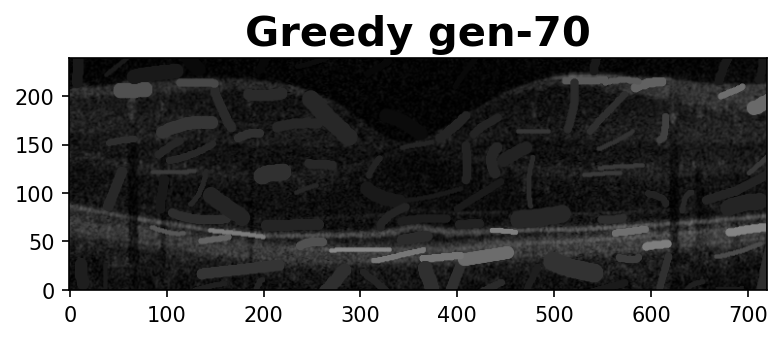

In [26]:
ga.run_generations(10)
ga.plot_clew()

Generation 71: 0.052  (took 0.30 seconds)
Generation 72: 0.052  (took 0.30 seconds)
Generation 73: 0.053  (took 0.30 seconds)
Generation 74: 0.053  (took 0.30 seconds)
Generation 75: 0.053  (took 0.30 seconds)
Generation 76: 0.054  (took 0.29 seconds)
Generation 77: 0.054  (took 0.30 seconds)
Generation 78: 0.054  (took 0.30 seconds)
Generation 79: 0.055  (took 0.29 seconds)
Generation 80: 0.055  (took 0.30 seconds)


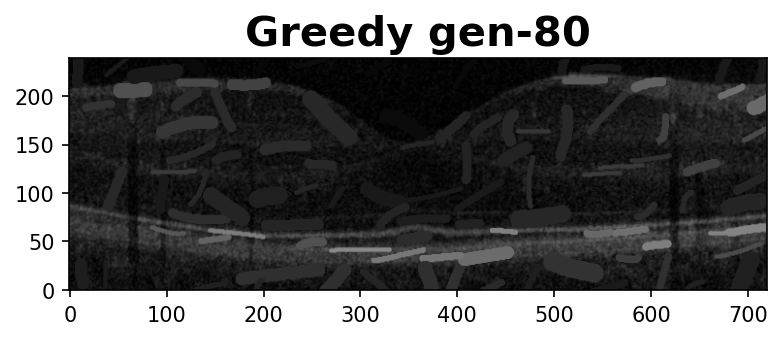

In [27]:
ga.run_generations(10)
ga.plot_clew()

Generation 81: 0.055  (took 0.32 seconds)
Generation 82: 0.055  (took 0.30 seconds)
Generation 83: 0.056  (took 0.30 seconds)
Generation 84: 0.056  (took 0.30 seconds)
Generation 85: 0.057  (took 0.30 seconds)
Generation 86: 0.057  (took 0.30 seconds)
Generation 87: 0.056  (took 0.30 seconds)
Generation 88: 0.056  (took 0.30 seconds)
Generation 89: 0.055  (took 0.30 seconds)
Generation 90: 0.055  (took 0.30 seconds)


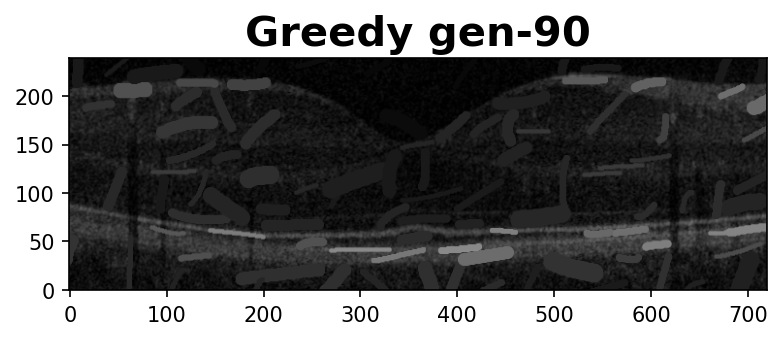

In [28]:
ga.run_generations(10)
ga.plot_clew()

Generation 91: 0.055  (took 0.30 seconds)
Generation 92: 0.055  (took 0.30 seconds)
Generation 93: 0.055  (took 0.30 seconds)
Generation 94: 0.054  (took 0.30 seconds)
Generation 95: 0.054  (took 0.30 seconds)
Generation 96: 0.054  (took 0.30 seconds)
Generation 97: 0.054  (took 0.30 seconds)
Generation 98: 0.054  (took 0.30 seconds)
Generation 99: 0.054  (took 0.30 seconds)
Generation 100: 0.054  (took 0.30 seconds)


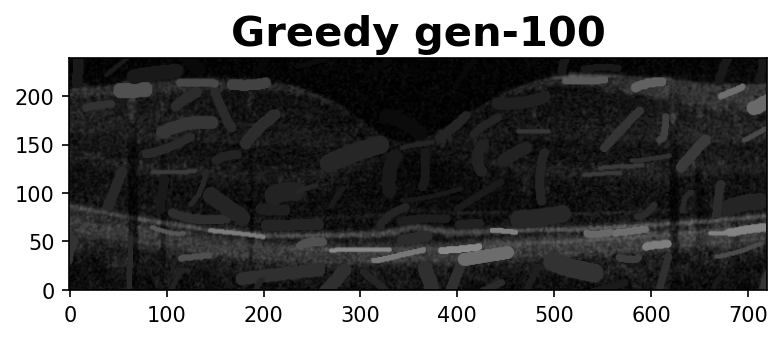

In [29]:
ga.run_generations(10)
ga.plot_clew()

Generation 101: 0.054  (took 0.30 seconds)
Generation 102: 0.055  (took 0.30 seconds)
Generation 103: 0.055  (took 0.30 seconds)
Generation 104: 0.055  (took 0.30 seconds)
Generation 105: 0.056  (took 0.30 seconds)
Generation 106: 0.056  (took 0.30 seconds)
Generation 107: 0.056  (took 0.30 seconds)
Generation 108: 0.056  (took 0.30 seconds)
Generation 109: 0.056  (took 0.30 seconds)
Generation 110: 0.056  (took 0.30 seconds)
Generation 111: 0.056  (took 0.30 seconds)
Generation 112: 0.057  (took 0.30 seconds)
Generation 113: 0.057  (took 0.30 seconds)
Generation 114: 0.057  (took 0.30 seconds)
Generation 115: 0.057  (took 0.30 seconds)
Generation 116: 0.057  (took 0.30 seconds)
Generation 117: 0.057  (took 0.30 seconds)
Generation 118: 0.058  (took 0.30 seconds)
Generation 119: 0.058  (took 0.30 seconds)
Generation 120: 0.058  (took 0.30 seconds)
Generation 121: 0.058  (took 0.30 seconds)
Generation 122: 0.058  (took 0.30 seconds)
Generation 123: 0.058  (took 0.30 seconds)
Generation 

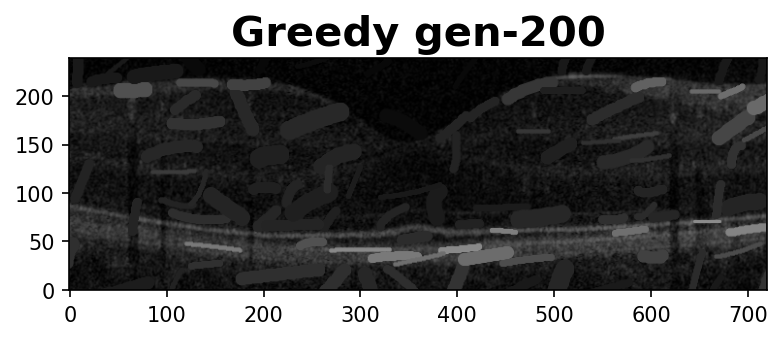

In [30]:
ga.run_generations(100)
ga.plot_clew()